In [1]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable, join
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import read_mist_models
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


## Scientific Background

[The Gaia mission](https://www.cosmos.esa.int/web/gaia/) is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia $G$-band photometric magnitude $G \lesssim 21$. By end of mission (~2022), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

In April 2018, Gaia publicly released its first major catalog of data — data release 2 or DR2 — which provides a subset of these data to anyone with an internet connection. In this tutorial, we will use astrometry, radial velocities, and photometry for a small subset of DR2 to study the kinematics of different types of stars in the Milky Way.

In [2]:
gaia_data = QTable.read('rcat_ngc6811_v0.fits')

In [3]:
gaia_data[:4]['GAIAEDR3_G', 'GAIAEDR3_BP', 'GAIAEDR3_RP', 'GAIAEDR3_ID', 'GAIAEDR3_PARALLAX', 'MemBool']

GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,GAIAEDR3_ID,GAIAEDR3_PARALLAX,MemBool
float64,float64,float64,int64,float64,float64
9.655539486232403,10.745175289323505,8.628050567983188,2128171967511009280,0.5100944059933568,0.0
13.337172295525619,13.551675872541242,12.983543309505581,2128122008451548672,0.8891264109236147,1.0
15.397562051384842,15.834741212700507,14.796243951628332,2128172001870752512,0.8325050724154034,0.0
13.10918249461778,13.410342462316569,12.646890273795137,2128175369125668992,1.1822681078706723,0.0


In [4]:
gaia_data.info()

<QTable length=5456>
                    name                     dtype     class     n_bad
------------------------------------------- ------- ------------ -----
                                      H3_ID float64 MaskedColumn  5456
                                      PS_ID   int64       Column     0
                                   TMASS_ID   int64       Column     0
                                    WISE_ID bytes28       Column     0
                                  UNWISE_ID bytes16       Column     0
                                    SDSS_ID   int64       Column     0
                                   GALEX_ID   int64       Column     0
                                     DES_ID   int64       Column     0
                                  DECAPS_ID   int64       Column     0
                                  UKIDSS_ID   int64       Column     0
                                APOPAYNE_ID   int64       Column     0
                                  LAMOST_ID   int32     

In [4]:
# Convert parallax to a Quantity with the correct unit
cluster_members = gaia_data[gaia_data['MemBool'] == 1]
parallax = cluster_members['GAIAEDR3_PARALLAX_CORRECTED'] * u.mas  # Gaia parallaxes are in milliarcseconds

# Compute distance
dist = coord.Distance(parallax=parallax)

# Get min and max distances
dist.min(), dist.max()

(<Distance 914.36582813 pc>, <Distance 1594.10258108 pc>)

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

In [12]:
M_G = cluster_members['GAIAEDR3_G'] * u.mag - dist.distmod
BP_RP = cluster_members['GAIAEDR3_BP'] - cluster_members['GAIAEDR3_RP']

Text(0, 0.5, '$M_G$')

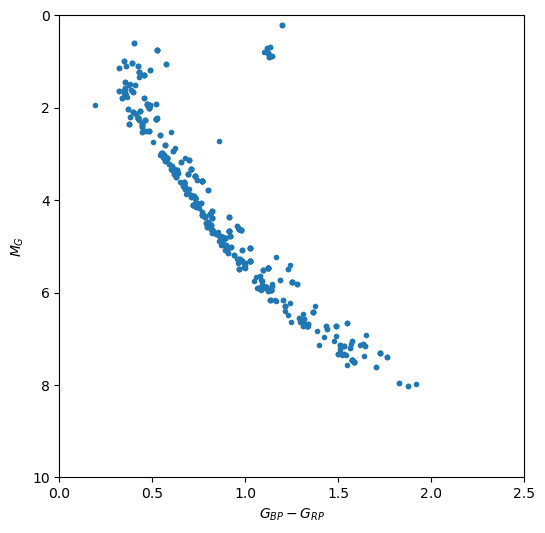

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=1)

ax.set_xlim(0, 2.5)
ax.set_ylim(10, 0)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In [14]:
#Read in the CMD file.
isocmd = read_mist_models.ISOCMD('MIST_iso_67f0218b46ba3.iso.cmd')
# Plot a CMD at log(age) = 9.04 in BP-RP & G bands.
age_ind = isocmd.age_index(9.04) #returns the index for the desired age
M_G_iso = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
BP_RP_iso = isocmd.isocmds[age_ind]['Gaia_BP_EDR3'] - isocmd.isocmds[age_ind]['Gaia_RP_EDR3']

Reading in: MIST_iso_67f0218b46ba3.iso.cmd


Text(0, 0.5, '$M_G$')

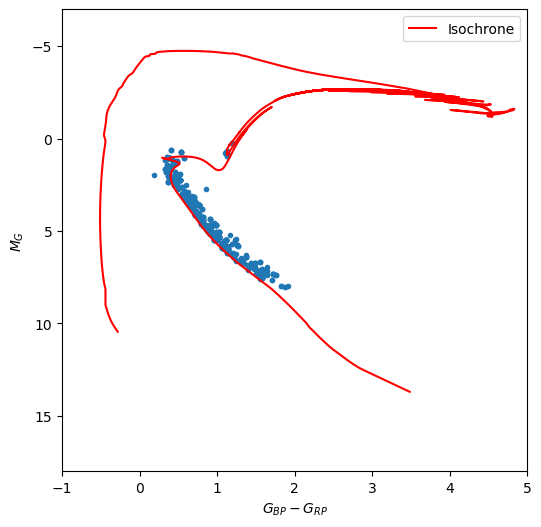

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', alpha=1)
ax.plot(BP_RP_iso, M_G_iso, label="Isochrone", color='red')

ax.legend()

ax.set_xlim(-1, 5)
ax.set_ylim(18, -7)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Text(0, 0.5, '$M_G$')

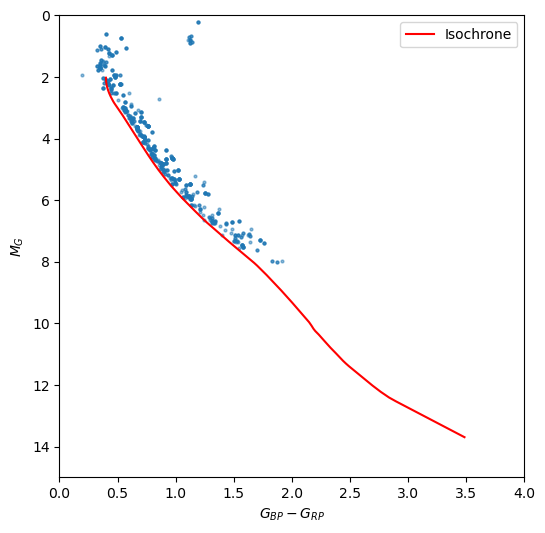

In [16]:
# Find the main sequence turnoff by checking where BP−RP starts increasing
for i in range(1, len(BP_RP_iso)):
    if BP_RP_iso[i] > BP_RP_iso[i - 1]:
        turnoff_idx = i - 1
        break

# Trim the isochrone up to and including the turnoff
BP_RP_iso_trimmed = BP_RP_iso[:turnoff_idx + 1]
M_G_iso_trimmed = M_G_iso[:turnoff_idx + 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', alpha=0.5, ms=4)
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed, label="Isochrone", color='red')

ax.legend()

ax.set_xlim(0, 4)
ax.set_ylim(15, 0)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In [17]:
# Interpolation setup
iso_interp = interp1d(BP_RP_iso_trimmed, M_G_iso_trimmed,
                      kind='linear', bounds_error=False, fill_value=np.nan)

BP_RP_plain = np.asarray(BP_RP.value)
M_G_interp = iso_interp(BP_RP_plain)

# Only use stars with a valid interpolated magnitude
valid = ~np.isnan(M_G_interp)
offsets = M_G.value[valid] - M_G_interp[valid]

In [18]:
# Start with an empty column filled with NaN
offset_column = np.full(len(cluster_members), np.nan)

# Fill in offsets where interpolation was valid
offset_column[valid] = offsets

# Add this column to the table
cluster_members['magnitude_offset'] = offset_column

In [19]:
cluster_members[:10]['GAIAEDR3_G', 'GAIAEDR3_BP', 'GAIAEDR3_RP', 'GAIAEDR3_ID', 'GAIAEDR3_PARALLAX_CORRECTED', 'MemBool', 'magnitude_offset']

GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,GAIAEDR3_ID,GAIAEDR3_PARALLAX_CORRECTED,MemBool,magnitude_offset
float64,float64,float64,int64,float64,float64,float64
13.337172295525619,13.551675872541242,12.983543309505581,2128122008451548672,0.9153434109236147,1.0,-0.24278813819701872
14.549580187770758,14.849076230975228,14.070146648777945,2128145957189232256,0.9109152172621372,1.0,-0.27868335819785006
14.699125767119874,15.014409189287331,14.216088900137866,2128151008070805888,0.9032140360831935,1.0,-0.2555593199048083
14.022416554799102,14.291599798561526,13.598220519751022,2128109123549687680,0.9244466560343109,1.0,-0.27768464210253097
13.243093599692413,13.50137615798098,12.828587509834955,2128147125420433280,0.9287368800301363,1.0,-0.9259918600009405
13.298758279698916,13.512050245304057,12.9479931315532,2128134824634071424,0.9046896744808937,1.0,-0.2825822126428257
15.558708536694255,15.946221434169777,14.964865271708058,2128140253472804736,0.7986273946397587,1.0,-0.5553332052384476
12.028426164806769,12.152631687760765,11.802042047212316,2128134549756169856,0.8629417940811268,1.0,nan
11.91532895269367,12.037883240685897,11.692978722373866,2128132758749075456,0.8763246035824093,1.0,nan


Text(0, 0.5, '$M_G$')

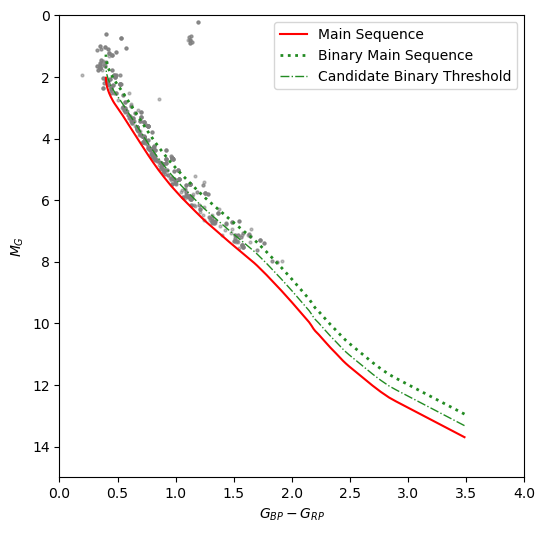

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', color='gray', alpha=0.5, ms=4)
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed, label="Main Sequence", color='red')
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed - 0.75, label="Binary Main Sequence", linestyle=':', color='#228B22', linewidth=2)
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed - 0.375, label="Candidate Binary Threshold", linestyle='-.', color='#228B22', linewidth=1)

ax.legend()

ax.set_xlim(0, 4)
ax.set_ylim(15, 0)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Text(0, 0.5, '$M_G$')

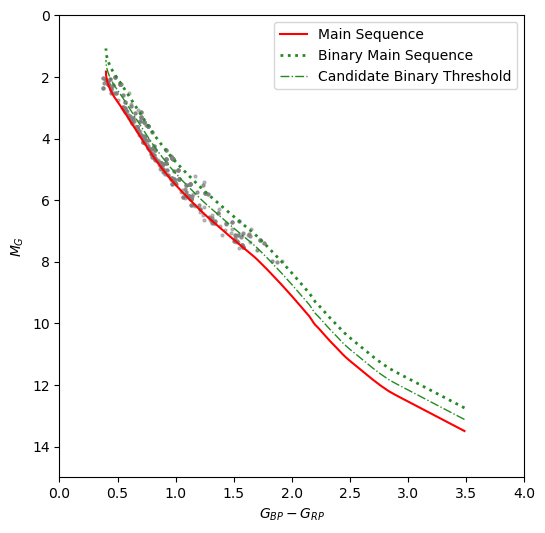

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

filter =(
    ((np.isnan(cluster_members['magnitude_offset'])) | (cluster_members['magnitude_offset'] > -2)) &
    (M_G.value > 2))

cluster_members_ms = cluster_members[filter]

parallax = cluster_members_ms['GAIAEDR3_PARALLAX_CORRECTED'] * u.mas  # Gaia parallaxes are in milliarcseconds
dist = coord.Distance(parallax=parallax)

M_G_ms = cluster_members_ms['GAIAEDR3_G'] * u.mag - dist.distmod
BP_RP_ms = cluster_members_ms['GAIAEDR3_BP'] - cluster_members_ms['GAIAEDR3_RP']

M_G_iso_trimmed -= 0.2

ax.plot(BP_RP_ms.value, M_G_ms.value, marker='.', linestyle='none', color='gray', alpha=0.5, ms=4)
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed, label="Main Sequence", color='red')
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed - 0.75, label="Binary Main Sequence", linestyle=':', color='#228B22', linewidth=2)
ax.plot(BP_RP_iso_trimmed, M_G_iso_trimmed - 0.375, label="Candidate Binary Threshold", linestyle='-.', color='#228B22', linewidth=1)

ax.legend()

ax.set_xlim(0, 4)
ax.set_ylim(15, 0)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Text(0, 0.5, '$M_G$ - MS')

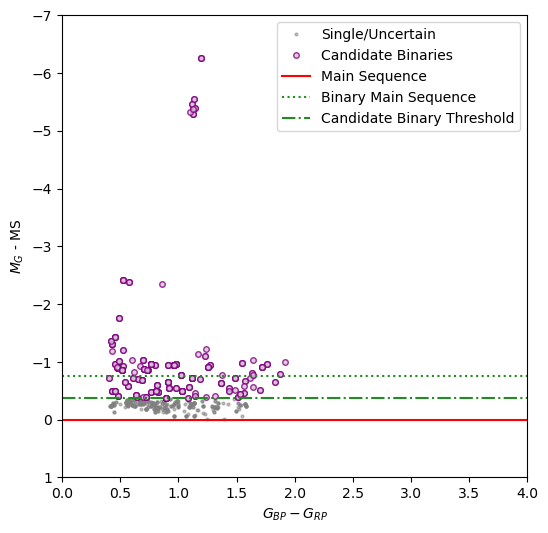

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

offsets = np.asarray(cluster_members['magnitude_offset'])
colors = np.asarray(BP_RP.value)

# Mask for stars below threshold
binary_mask = offsets < -0.375
single_mask = ~binary_mask

# Plot non-binaries
ax.plot(colors[single_mask], offsets[single_mask], marker='.', linestyle='none', color='gray', alpha=0.5, ms=4, label='Single/Uncertain')

# Plot candidate binaries
ax.plot(colors[binary_mask], offsets[binary_mask], marker='o', linestyle='none', color='purple', alpha=0.8, ms=4, markerfacecolor='#D8BFD8',
        label='Candidate Binaries')

ax.axhline(0, color='red', label='Main Sequence')
ax.axhline(-0.75, linestyle=':', color='#228B22', label='Binary Main Sequence')
ax.axhline(-0.375, linestyle='-.', color='#228B22', label='Candidate Binary Threshold')

ax.legend()
ax.set_xlim(0, 4)
ax.set_ylim(1, -7)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$ - MS')

Text(0, 0.5, '$M_G$ - MS')

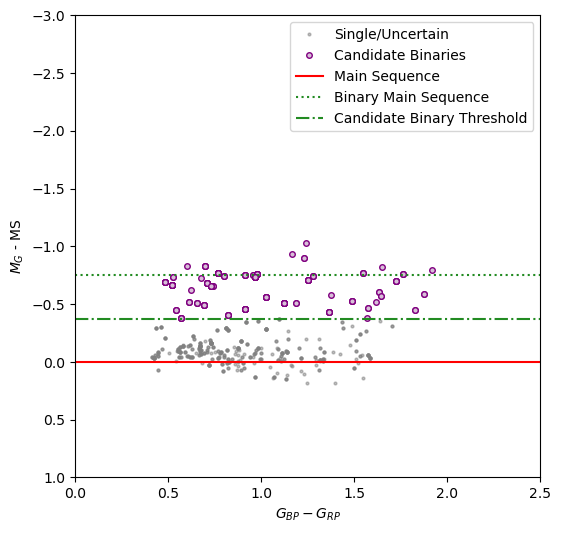

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

offsets = np.asarray(cluster_members_ms['magnitude_offset']) + 0.2
colors = np.asarray(BP_RP_ms.value)

# Mask for stars below threshold
binary_mask = offsets < -0.375
single_mask = ~binary_mask

# Plot non-binaries
ax.plot(colors[single_mask], offsets[single_mask], marker='.', linestyle='none', color='gray', alpha=0.5, ms=4, label='Single/Uncertain')

# Plot candidate binaries
ax.plot(colors[binary_mask], offsets[binary_mask], marker='o', linestyle='none', color='purple', alpha=1, ms=4, markerfacecolor='#D8BFD8',
        label='Candidate Binaries')

ax.axhline(0, color='red', label='Main Sequence')
ax.axhline(-0.75, linestyle=':', color='#228B22', label='Binary Main Sequence')
ax.axhline(-0.375, linestyle='-.', color='#228B22', label='Candidate Binary Threshold')

ax.legend()
ax.set_xlim(0, 2.5)
ax.set_ylim(1, -3)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$ - MS')

In [24]:
len(np.unique(cluster_members_ms["GAIAEDR3_ID"][binary_mask]))

46

In [25]:
unique_ids, unique_idx = np.unique(cluster_members_ms["GAIAEDR3_ID"][binary_mask], return_index=True)
candidates = cluster_members_ms[unique_idx]

In [26]:
candidates

H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,SDSS_ID,GALEX_ID,DES_ID,DECAPS_ID,UKIDSS_ID,APOPAYNE_ID,LAMOST_ID,GAIADR1_ID,GAIADR2_ID,GAIAEDR3_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,WISE_W3,WISE_W4,UNWISE_W1,UNWISE_W2,GALEX_NUV,GALEX_FUV,DES_G,DES_R,DES_I,DES_Z,DES_Y,DECAPS_G,DECAPS_R,DECAPS_I,DECAPS_Z,DECAPS_Y,UKIDSS_J,UKIDSS_H,UKIDSS_K,GAIADR2_G,GAIADR2_BP,GAIADR2_RP,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,WISE_W3_ERR,WISE_W4_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GALEX_NUV_ERR,GALEX_FUV_ERR,DES_G_ERR,DES_R_ERR,DES_I_ERR,DES_Z_ERR,DES_Y_ERR,DECAPS_G_ERR,DECAPS_R_ERR,DECAPS_I_ERR,DECAPS_Z_ERR,DECAPS_Y_ERR,UKIDSS_J_ERR,UKIDSS_H_ERR,UKIDSS_K_ERR,GAIADR2_G_ERR,GAIADR2_BP_ERR,GAIADR2_RP_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,APOPAYNE_TEFF,APOPAYNE_LOGG,APOPAYNE_VMIC,APOPAYNE_VMAC,APOPAYNE_FeH,APOPAYNE_CH,APOPAYNE_NH,APOPAYNE_OH,APOPAYNE_MgH,APOPAYNE_AlH,APOPAYNE_SiH,APOPAYNE_SH,APOPAYNE_KH,APOPAYNE_CaH,APOPAYNE_TiH,APOPAYNE_CrH,APOPAYNE_MnH,APOPAYNE_NiH,APOPAYNE_CuH,APOPAYNE_C12C13,LAMOST_TEFF,LAMOST_LOGG,LAMOST_FeH,LAMOST_RV,GAIADR2_RA,GAIADR2_DEC,GAIADR2_RA_ERROR,GAIADR2_DEC_ERROR,GAIADR2_PARALLAX,GAIADR2_PARALLAX_ERROR,GAIADR2_PARALLAX_OVER_ERROR,GAIADR2_PMRA,GAIADR2_PMDEC,GAIADR2_PMRA_ERROR,GAIADR2_PMDEC_ERROR,GAIADR2_PHOT_BP_RP_EXCESS_FACTOR,GAIADR2_VISIBILITY_PERIODS_USED,GAIADR2_ASTROMETRIC_EXCESS_NOISE,GAIADR2_ASTROMETRIC_EXCESS_NOISE_SIG,GAIADR2_ASTROMETRIC_SIGMA5D_MAX,GAIADR2_ASTROMETRIC_CHI2_AL,GAIADR2_ASTROMETRIC_N_GOOD_OBS_AL,GAIADR2_RUWE,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,HDBscan_MemProb,HDBscan_Cluster,HDBscan_Stability,MemBool,MJD,DATE-OBS,starname,Av,Av_err,Av_lerr,Av_uerr,Teff,Teff_err,Teff_lerr,Teff_uerr,[Fe/H],[Fe/H]_err,[Fe/H]_lerr,[Fe/H]_uerr,[a/Fe],[a/Fe]_err,[a/Fe]_lerr,[a/Fe]_uerr,dist,dist_err,dist_lerr,dist_uerr,log(R),log(R)_err,log(R)_lerr,log(R)_uerr,log(g),log(g)_err,log(g)_lerr,log(g)_uerr,lsf,lsf_err,lsf_lerr,lsf_uerr,pc0,pc0_err,pc0_lerr,pc0_uerr,pc1,pc1_err,pc1_lerr,pc1_uerr,pc2,pc2_err,pc2_lerr,pc2_uerr,pc3,pc3_err,pc3_lerr,pc3_uerr,photjitter,photjitter_err,photjitter_lerr,photjitter_uerr,specjitter,specjitter_err,specjitter_lerr,specjitter_uerr,vmic,vmic_err,vmic_lerr,vmic_uerr,vrad,vrad_err,vrad_lerr,vrad_uerr,vstar,vstar_err,vstar_lerr,vstar_uerr,chisq_spec,nspecpix,chisq_phot,nbands,lnLike,SNR,magnitude_offset
float64,int64,int64,bytes28,bytes16,int64,int64,int64,int64,int64,int64,int32,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32

In [76]:
catalog = candidates["GAIAEDR3_ID", "GAIAEDR3_G", "GAIAEDR3_BP", "GAIAEDR3_RP", "GAIAEDR3_PARALLAX_CORRECTED", "GAIAEDR3_RUWE"]
catalog.write("catalog.csv", format="csv", overwrite=True)

Text(0, 0.5, '$M_G$')

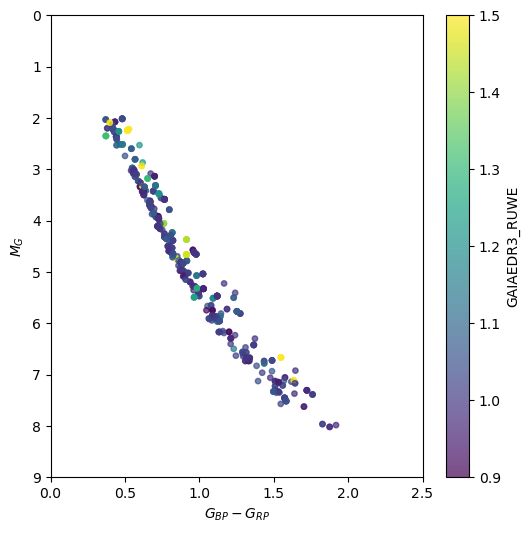

In [27]:
RUWE = cluster_members_ms['GAIAEDR3_RUWE']

fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(BP_RP_ms.value, M_G_ms.value, c=RUWE, vmin=0.9, vmax=1.5, cmap='viridis', s=15, alpha=0.7)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('GAIAEDR3_RUWE')

ax.set_xlim(0, 2.5)
ax.set_ylim(9, 0)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In [28]:
csvfile = QTable.read('unimodalcheck_200M.csv', format='csv')
csvfile['id'] = csvfile['id'].astype('int64')
csvfile = csvfile['id', 'num_RV']

In [29]:
merged_table = join(cluster_members_ms, csvfile, 
                    keys_left='GAIAEDR3_ID', keys_right='id', 
                    join_type='left')

merged_table['num_RV'].fill_value = 0
merged_table['num_RV'] = merged_table['num_RV'].filled()
del merged_table['id']

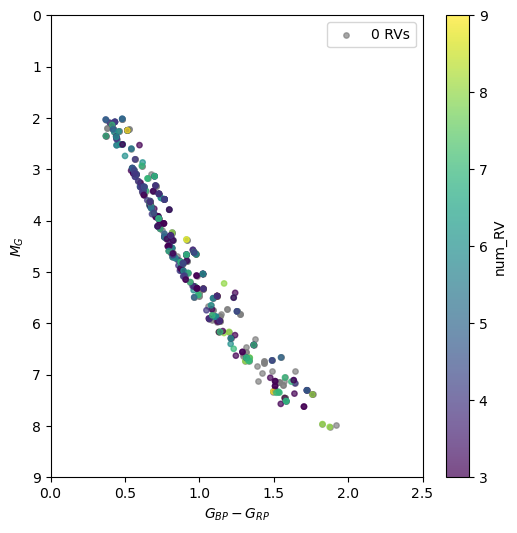

In [30]:
num_RV = merged_table['num_RV']

# Create masks
mask_zero = (num_RV == 0)
mask_nonzero = (num_RV > 0)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot stars with 0 RVs (gray)
ax.scatter(BP_RP_ms.value[mask_zero], M_G_ms.value[mask_zero],
           color='gray', s=15, alpha=0.7, label='0 RVs')

# Plot stars with >0 RVs (colored)
sc = ax.scatter(BP_RP_ms.value[mask_nonzero], M_G_ms.value[mask_nonzero],
                c=num_RV[mask_nonzero], cmap='viridis', s=15, alpha=0.7)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('num_RV')

ax.set_xlim(0, 2.5)
ax.set_ylim(9, 0)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

ax.legend()

Text(0, 0.5, '$M_G$ - MS')

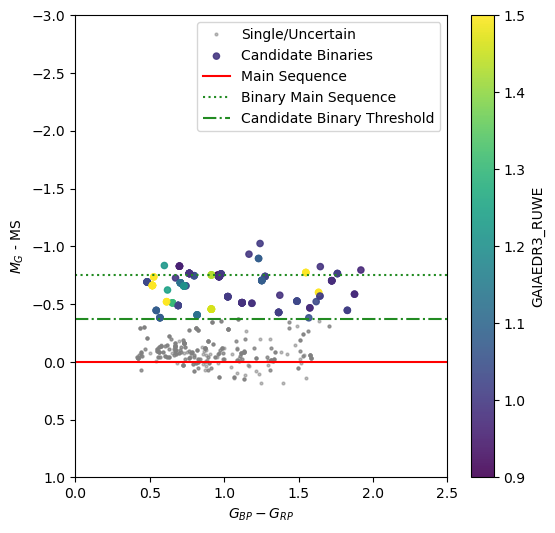

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

offsets = np.asarray(cluster_members_ms['magnitude_offset']) + 0.2
colors = np.asarray(BP_RP_ms.value)
RUWE = cluster_members_ms['GAIAEDR3_RUWE']

binary_mask = offsets < -0.375
single_mask = ~binary_mask

# Plot non-binaries (gray)
ax.plot(colors[single_mask], offsets[single_mask],
        marker='.', linestyle='none', color='gray', alpha=0.5, ms=4, label='Single/Uncertain')

# Plot candidate binaries (colored by RUWE)
sc = ax.scatter(colors[binary_mask], offsets[binary_mask],
                c=RUWE[binary_mask], cmap='viridis', vmin=0.9, vmax=1.5,
                marker='o', s=20, alpha=0.9, label='Candidate Binaries')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('GAIAEDR3_RUWE')

ax.axhline(0, color='red', label='Main Sequence')
ax.axhline(-0.75, linestyle=':', color='#228B22', label='Binary Main Sequence')
ax.axhline(-0.375, linestyle='-.', color='#228B22', label='Candidate Binary Threshold')

ax.legend()
ax.set_xlim(0, 2.5)
ax.set_ylim(1, -3)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$ - MS')

Text(0, 0.5, '$M_G$ - MS')

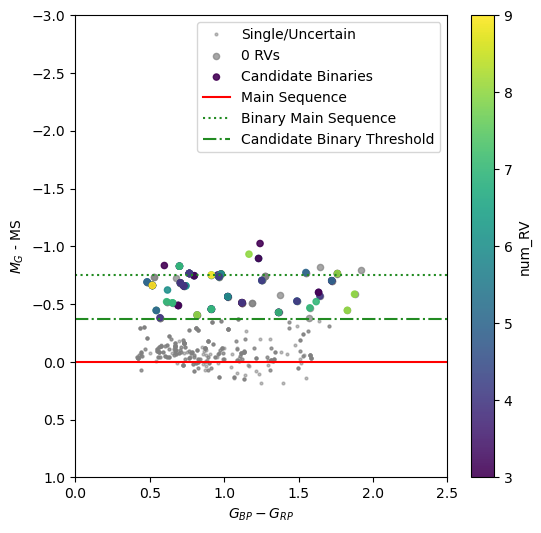

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

offsets = np.asarray(cluster_members_ms['magnitude_offset']) + 0.2
colors = np.asarray(BP_RP_ms.value)
num_RV = merged_table['num_RV']

binary_mask = offsets < -0.375
single_mask = ~binary_mask

binary_zero_RV_mask = binary_mask & (num_RV == 0)
binary_nonzero_RV_mask = binary_mask & (num_RV > 0)

# Plot non-binaries
ax.plot(colors[single_mask], offsets[single_mask], marker='.', linestyle='none', color='gray', alpha=0.5, ms=4, label='Single/Uncertain')

# Plot stars with 0 RVs (gray)
ax.scatter(colors[binary_zero_RV_mask], offsets[binary_zero_RV_mask],
           color='gray', s=20, alpha=0.7, label='0 RVs')

# Plot stars with >0 RVs (colored)
sc = ax.scatter(colors[binary_nonzero_RV_mask], offsets[binary_nonzero_RV_mask],
                c=num_RV[binary_nonzero_RV_mask], cmap='viridis', s=20, alpha=0.9, label='Candidate Binaries')

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('num_RV')

ax.axhline(0, color='red', label='Main Sequence')
ax.axhline(-0.75, linestyle=':', color='#228B22', label='Binary Main Sequence')
ax.axhline(-0.375, linestyle='-.', color='#228B22', label='Candidate Binary Threshold')

ax.legend()
ax.set_xlim(0, 2.5)
ax.set_ylim(1, -3)
ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$ - MS')